# Lorenz attractor — Ensemble Kalman filter

we show how easy is to extend our method to other filtering algorithms.

In [2]:
import jax
import chex
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from rebayes_mini.methods import ensemble_kalman_filter as enkf

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "ANN-1": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
}

In [4]:
def rk4_step(y, i, dt, f):
    h = dt
    t = dt * i
    k1 = h * f(y, t)
    k2 = h * f(y + k1 / 2, dt * i + h / 2)
    k3 = h * f(y + k2 / 2, t + h / 2)
    k4 = h * f(y + k3, t + h)

    y_next = y + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

    

@partial(jax.jit, static_argnames=("f",))
def rk4(ys, dt, N, f):
    """
    Based on
    https://colab.research.google.com
    github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver
    """
    @jax.jit
    def step(i, ys):
        ysi = rk4_step(ys[i - 1], i, dt, f)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

## 3D Lorenz

In [5]:
sigma = 10.
beta = 8./3
rho = 28.


def f(state, t):
    x, y, z = state
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return jnp.array([xdot, ydot, zdot])

y0 = jnp.ones(3)
N = 5_000
ys = jnp.zeros((N,) + y0.shape)
ys = ys.at[0].set(y0)
res = rk4(ys, 0.004, N, f)

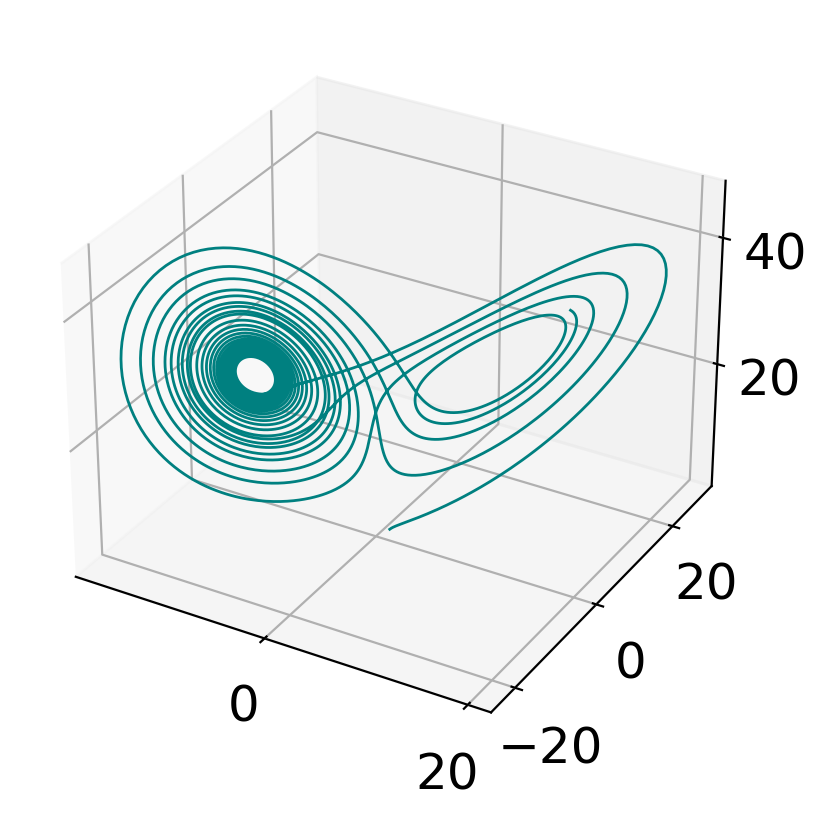

In [6]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*res.T, lw=1.0, c="teal")

# Modified Lorenz 96 model
See https://en.wikipedia.org/wiki/Lorenz_96_model


$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$
with 
* $F_k \sim {\cal N}(8, 1)$

In [7]:
D = 40
F = 8.0
ixs = jnp.arange(D)

key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval = jax.random.split(key, 3)
x0 = jax.random.normal(key_init, (D,)) + F

key_state, key_measurement = jax.random.split(key_sim)

In [8]:
@partial(jax.vmap, in_axes=(None, 0))
def fcoord(x, k):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, *args):
    keyt = jax.random.fold_in(key_state, t)
    err = jax.random.normal(keyt, shape=(D,))
    xdot = fcoord(x, ixs) + F + err
    return xdot

In [9]:
N = 60
dt = 0.05
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
xs = rk4(xs, dt, N, f)
ys = xs + jax.random.normal(key_measurement, xs.shape)

In [10]:
ys_corrupted = ys.copy()
p_err = 0.01
errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys_corrupted.shape)
ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map
err_where = np.where(errs_map)

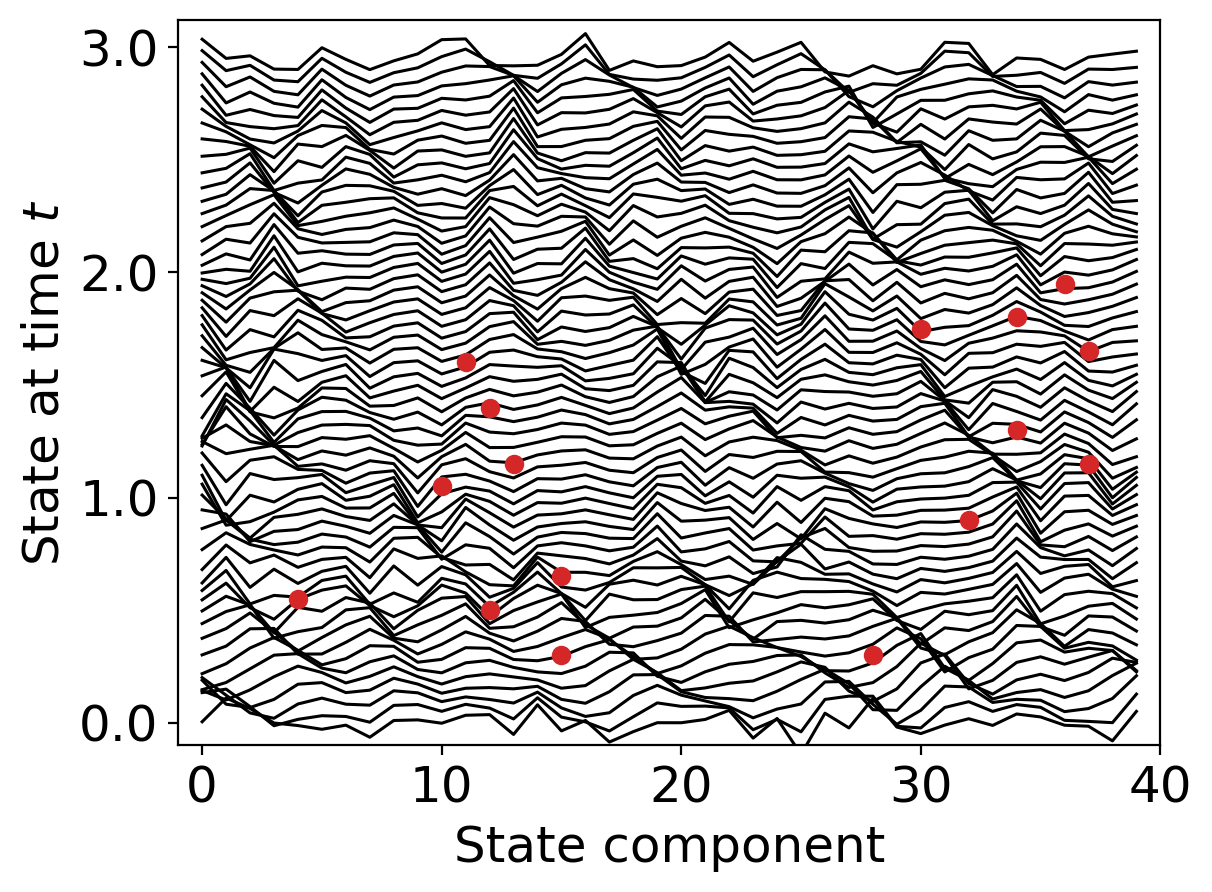

In [11]:
xs_cpu = np.array(xs)
for n, row in enumerate(xs):
    # plt.axhline(y=n, c="tab:gray", zorder=1, alpha=0.2)
    plt.plot((row - row.mean()) / row.std() + n, c="black", zorder=1, linewidth=1.1)
plt.xlabel("State component")
plt.ylabel("State at time $t$")
pos, vals = plt.yticks()
plt.yticks(pos[1:-1], pos[1:-1] * dt);
plt.ylim(bottom=pos[1] - 2, top=pos[-2] * 1.04)
plt.xlim(-1, D)
plt.scatter(*err_where, c="tab:red")

plt.tight_layout()
plt.savefig("./figures/lorenz96-waves.png", dpi=300)

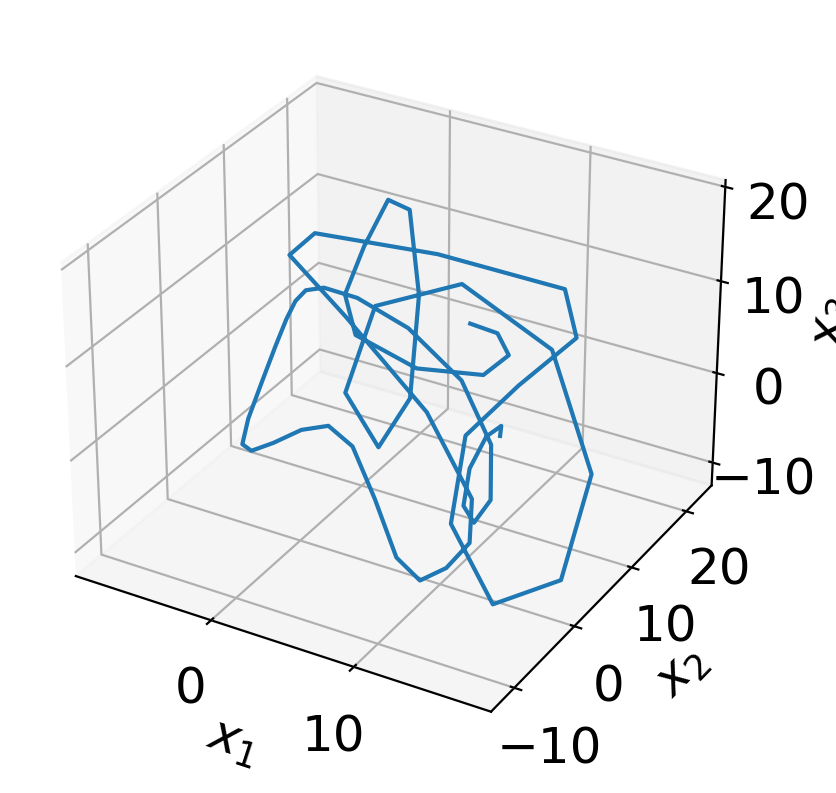

In [12]:
# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

# The ensemble Kalman filter

## Classical example

>  There are indications that in nonlinear and nonGaussian systems the sampling based EnKF variants should be preferable over their square root counterparts

In [13]:
N = 10 ** 4
dt = 0.05
x0 = jax.random.normal(key_init, (D,))
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
xs = rk4(xs, dt, N, f)
ys = xs + jax.random.normal(key_measurement, xs.shape)
# ys = xs + jax.random.t(key_measurement, df=2.01, shape=xs.shape)

In [14]:
range_time = np.arange(N) * dt

In [15]:
def callback(particles, particles_pred, y, i, xs):
    return jnp.sqrt(jnp.power(particles.mean(axis=0) - xs[i], 2).mean())

def callback_fn(particles, particles_pred, y, i):
    return jnp.sqrt(jnp.power(particles.mean(axis=0) - xs[i], 2).mean())

In [16]:
def latent_fn(x, key, i):
    """
    State function
    """
    err = jax.random.normal(key, (D,))
    def f(x, t):
        return fcoord(x, ixs) + F + err
    
    return rk4_step(x, i, dt, f)


def obs_fn(x, key, i):
    """
    Measurement function
    """
    err = jax.random.normal(key, (D,))
    return x + err

In [17]:
n_particles = 1000
agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)

key_init_particles, key_scan = jax.random.split(key_eval, 2)

X0 = agent.init_bel(key_init_particles, D)
particles_end, errs = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)

jnp.median(errs[100:])

Array(0.43275148, dtype=float32)

In [18]:
# Baseline error
jnp.mean(jnp.power(xs - ys, 2).mean(axis=1))

Array(1.0008385, dtype=float32)

## Corrupted example

In [19]:
ys_corrupted = ys.copy()
p_err = 0.001
errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys_corrupted.shape)
ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map

In [20]:
p_err * D # Probability of a corruption per timestep

0.04

## WL EnEKF

In [21]:
agent = enkf.WLEnsembleKalmanFilter(latent_fn, obs_fn, n_particles, c=10.0)
n_particles = 1000
X0 = agent.init_bel(key_eval, D)

In [22]:
particles_end, errs_wenkf = agent.scan(X0, key_eval, ys_corrupted, callback_fn=callback_fn)

In [23]:
jnp.mean(errs_wenkf[100:])

Array(0.448752, dtype=float32)

In [24]:
ix_init = 50
ix_end = 450
ix_steps = np.arange(ix_init, ix_end) * dt

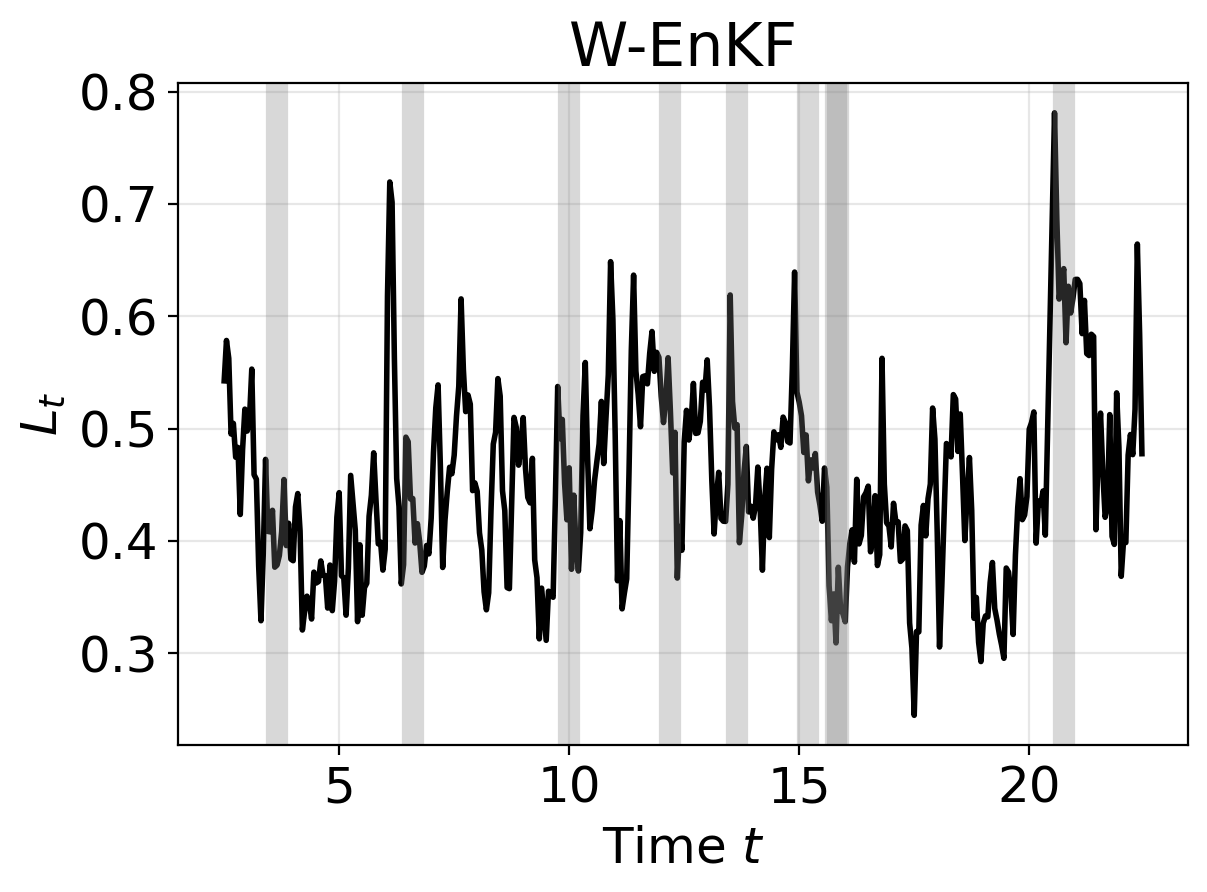

In [25]:
ixs_where, *_ = np.where(errs_map.any(axis=1)[ix_init:ix_end])

plt.plot(ix_steps, errs_wenkf[ix_init:ix_end], c="black", linewidth=2)
for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=8)
plt.grid(alpha=0.3)
plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")
plt.title("W-EnKF")
plt.tight_layout()
plt.savefig("./figures/lorenz96-wlenkf-sample.png", dpi=300)

## Huberized EnEKF

In [26]:
agent = enkf.HubEnsembleKalmanFilter(latent_fn, obs_fn, n_particles, clipping_height=10.0)
n_particles = 1000
X0 = agent.init_bel(key_eval, D)

In [27]:
particles_end, errs_hubenkf = agent.scan(X0, key_eval, ys_corrupted, callback_fn=callback_fn)

In [28]:
jnp.mean(errs_hubenkf[100:])

Array(0.45016345, dtype=float32)

In [29]:
ix_init = 50
ix_end = 450
ix_steps = np.arange(ix_init, ix_end) * dt

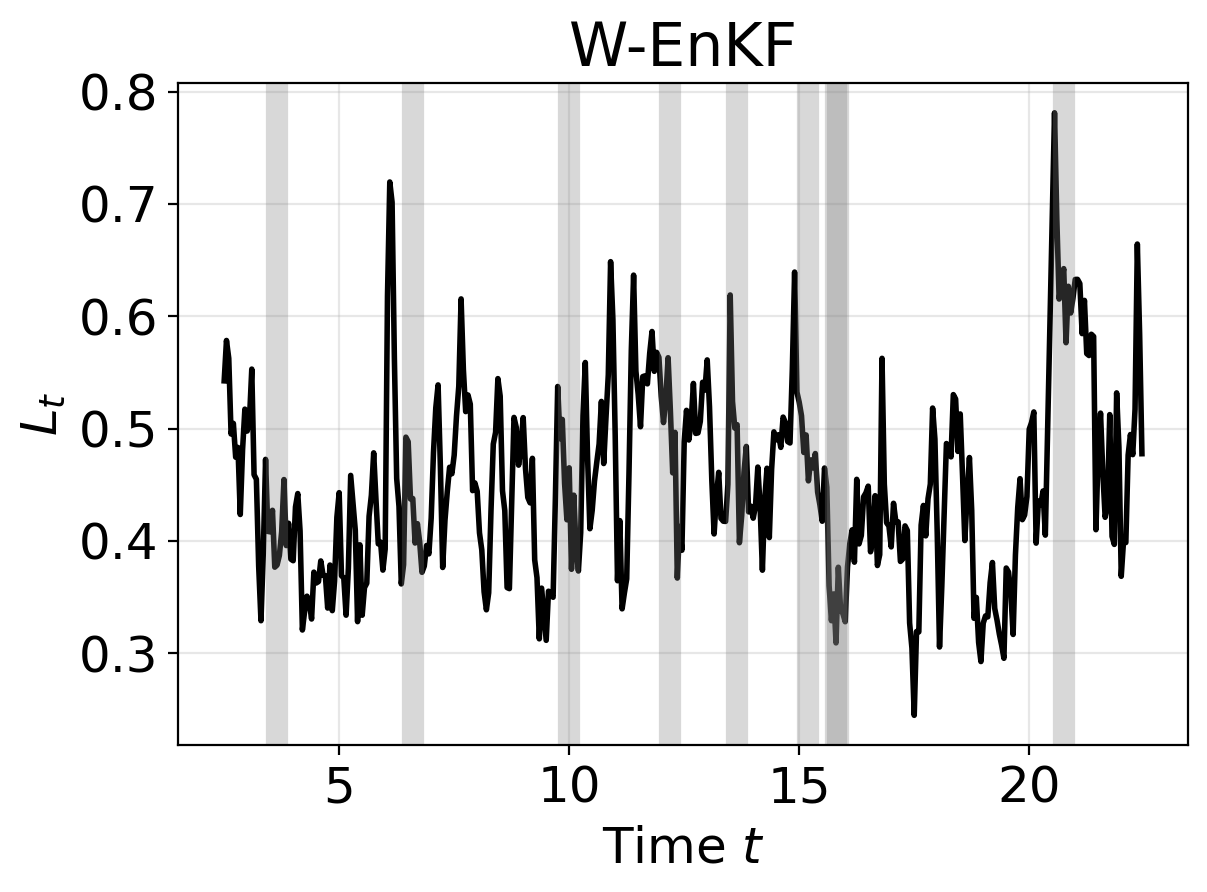

In [30]:
ixs_where, *_ = np.where(errs_map.any(axis=1)[ix_init:ix_end])

plt.plot(ix_steps, errs_wenkf[ix_init:ix_end], c="black", linewidth=2)
for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=8)
plt.grid(alpha=0.3)
plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")
plt.title("W-EnKF")
plt.tight_layout()
plt.savefig("./figures/lorenz96-wlenkf-sample.png", dpi=300)

## Base EnEKF

In [31]:
agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
n_particles = 1000
X0 = agent.init_bel(key_eval, D)

In [32]:
particles_end, errs_enkf = agent.scan(X0, key_eval, ys_corrupted, callback_fn=callback_fn)

In [33]:
jnp.mean(errs_enkf[100:])

Array(2.0644472, dtype=float32)

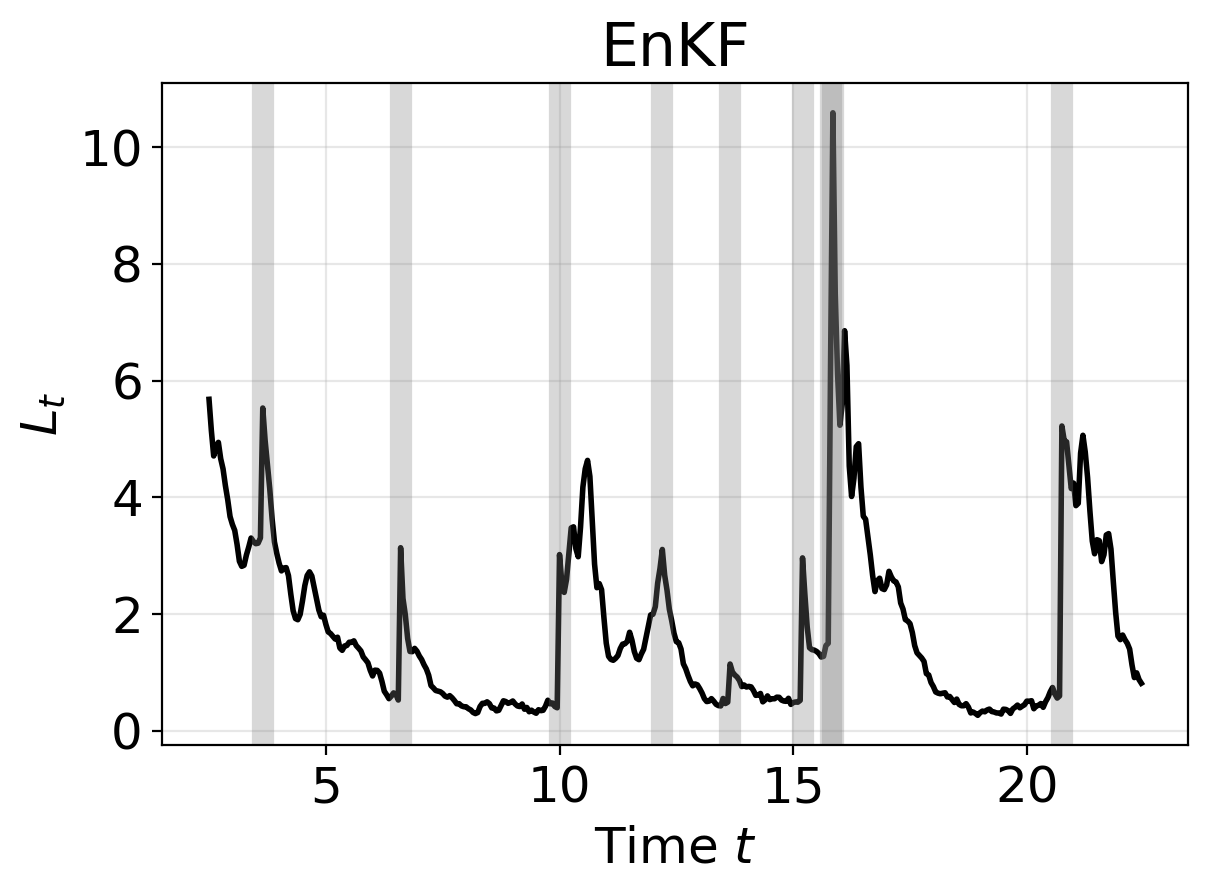

In [34]:
ixs_where, *_ = np.where(errs_map.any(axis=1)[ix_init:ix_end])

plt.plot(ix_steps, errs_enkf[ix_init:ix_end], c="black", linewidth=2)
for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=8)
plt.grid(alpha=0.3)
plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")
plt.title("EnKF")
plt.tight_layout()
plt.savefig("./figures/lorenz96-enkf-sample.png", dpi=300)

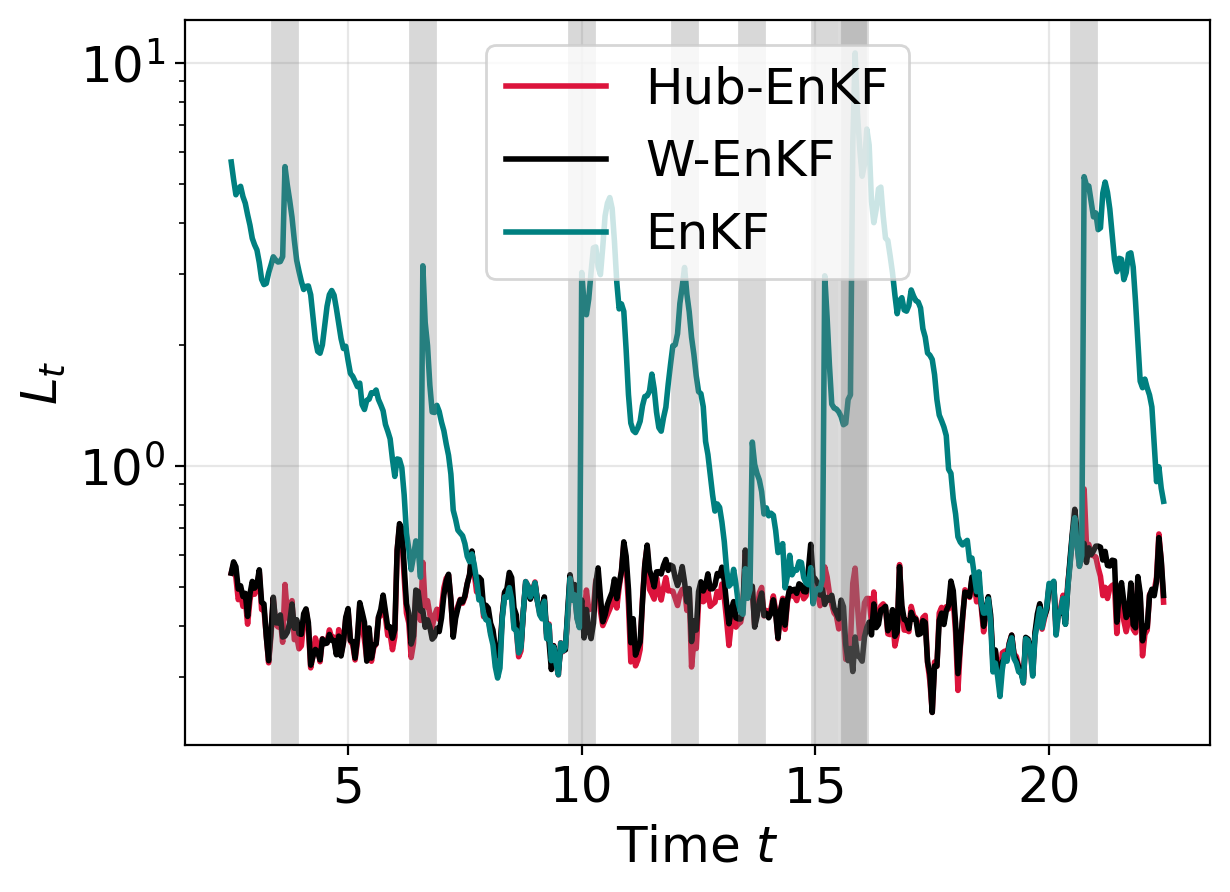

In [35]:
plt.plot(ix_steps, errs_hubenkf[ix_init:ix_end], c="crimson", linewidth=2, label="Hub-EnKF")
plt.plot(ix_steps, errs_wenkf[ix_init:ix_end], c="black", linewidth=2, label="W-EnKF")
plt.plot(ix_steps, errs_enkf[ix_init:ix_end], c="teal", linewidth=2, label="EnKF")

for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=10)
plt.grid(alpha=0.3)

plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")

plt.legend()
plt.tight_layout()
plt.yscale("log")
plt.grid(alpha=0.3)
plt.savefig("./figures/lorenz96-wenkf-enkf-sample.png", dpi=300)

## Corrupted measurements

In [36]:
err_where = np.where(errs_map)

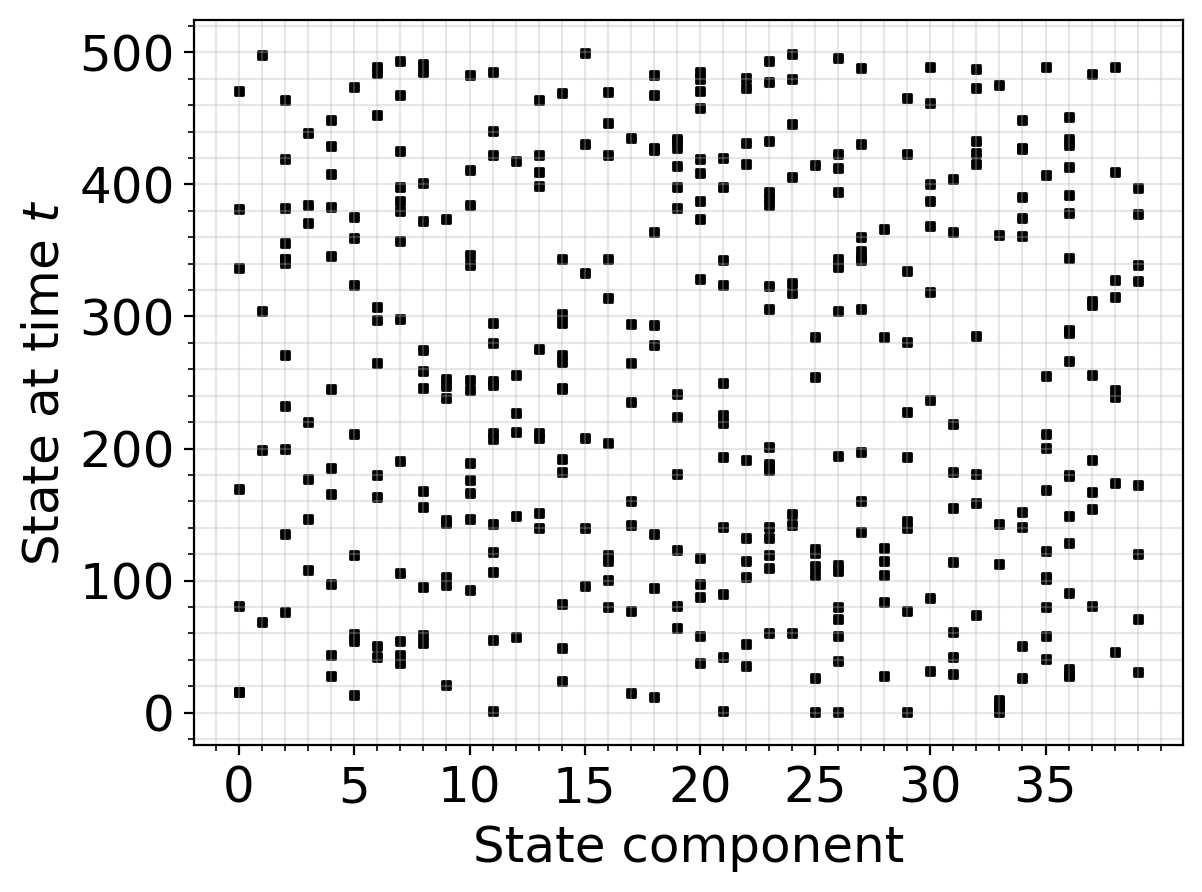

In [37]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots()
yerr, xerr = err_where
plt.scatter(xerr, yerr * dt, s=10, c="black", marker="s")
pos, _ = plt.xticks()
plt.xlabel("State component")
plt.ylabel("State at time $t$")
plt.tight_layout()

ax.set_xticks(np.arange(0, D, 5))

# Enable minor ticks on the x-axis
ax.minorticks_on()

# Set the number of minor ticks between major ticks
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.grid(alpha=0.3, zorder=0, which="both")
# plt.savefig("./figures/lorenz96-err-where.png", dpi=300)

In [38]:
# Proportion of timesteps in which at least one state component had an outlier value
errs_map.any(axis=1).mean()

Array(0.0402, dtype=float32)

In [39]:
errs_map.mean()

Array(0.00102, dtype=float32)

# Multiple runs
## The effect of the parameter $c$

In [51]:
p_err = 0.001

@jax.jit
@partial(jax.vmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def hubenkf_filter(c, key):
    key_create, key_measurements, key_init, key_run, key_corrupt = jax.random.split(key, 5)

    x0 = jax.random.normal(key_create, (D,))
    xs = jnp.zeros((N,) + x0.shape)
    xs = xs.at[0].set(x0)
    xs = rk4(xs, dt, N, f)
    
    # ys_corrupted = xs + jax.random.t(key_measurement, df=2.01, shape=xs.shape)
    
    # ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    # errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    # ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map
    
    ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    ys_corrupted = ys_corrupted * (~errs_map) + 2 * ys_corrupted * errs_map

    
    agent = enkf.HubEnsembleKalmanFilter(latent_fn, obs_fn, n_particles, clipping_height=c)
    X0 = agent.init_bel(key_init, D)
    callback_fn = partial(callback, xs=xs)
    particles_end, errs = agent.scan(X0, key_run, ys_corrupted, callback_fn=callback_fn)

    return errs[100:].mean(axis=-1)

    
@jax.jit
@partial(jax.vmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def wlenkf_filter(c, key):
    key_create, key_measurements, key_init, key_run, key_corrupt = jax.random.split(key, 5)

    x0 = jax.random.normal(key_create, (D,))
    xs = jnp.zeros((N,) + x0.shape)
    xs = xs.at[0].set(x0)
    xs = rk4(xs, dt, N, f)
    
    # ys_corrupted = xs + jax.random.t(key_measurement, df=2.01, shape=xs.shape)
    
    # ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    # errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    # ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map
    
    ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    ys_corrupted = ys_corrupted * (~errs_map) + 2 * ys_corrupted * errs_map

    
    agent = enkf.WLEnsembleKalmanFilter(latent_fn, obs_fn, n_particles, c=c)
    X0 = agent.init_bel(key_init, D)
    callback_fn = partial(callback, xs=xs)
    particles_end, errs = agent.scan(X0, key_run, ys_corrupted, callback_fn=callback_fn)

    return errs[100:].mean(axis=-1)

@jax.jit
@jax.vmap
def enkf_filter(key):
    key_create, key_measurements, key_init, key_run, key_corrupt = jax.random.split(key, 5)

    x0 = jax.random.normal(key_create, (D,))
    xs = jnp.zeros((N,) + x0.shape)
    xs = xs.at[0].set(x0)
    xs = rk4(xs, dt, N, f)
    
    
    # ys_corrupted = xs + jax.random.t(key_measurement, df=2.01, shape=xs.shape)
    
    # ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    # errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    # ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map
    
    ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    ys_corrupted = ys_corrupted * (~errs_map) + 2 * ys_corrupted * errs_map

    
    agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
    X0 = agent.init_bel(key_init, D)
    callback_fn = partial(callback, xs=xs)
    particles_end, errs = agent.scan(X0, key_run, ys_corrupted, callback_fn=callback_fn)

    return errs[100:].mean(axis=-1)

In [65]:
# c_values = jnp.linspace(3, 20, 8 * 3)
c_values = jnp.linspace(5, 20, 8 * 3)
sharding = jax.sharding.PositionalSharding(jax.devices())
c_values = jax.device_put(c_values, sharding)

In [66]:
n_trials = 20
keys_eval = jax.random.split(key_eval, n_trials)

## EnKF

In [43]:
%%time
errs_enkf = enkf_filter(keys_eval).block_until_ready()
errs_enkf = errs_enkf[~jnp.isnan(errs_enkf)]
errs_enkf.shape

CPU times: user 16.1 s, sys: 419 ms, total: 16.6 s
Wall time: 22 s


(40,)

### WL-EnKF

In [67]:
%%time
errs_wlenkf = wlenkf_filter(c_values, keys_eval).block_until_ready()

CPU times: user 180 ms, sys: 77.3 ms, total: 257 ms
Wall time: 2min 24s


In [68]:
err_mean_wlenkf = jnp.nanmean(errs_wlenkf, axis=0)
err_mean_wlenkf

Array([0.43888602, 0.4385924 , 0.43875653, 0.439002  , 0.43941292,
       0.4397238 , 0.4400564 , 0.44034138, 0.44072315, 0.44100246,
       0.4413351 , 0.44169566, 0.44206533, 0.44246814, 0.44284207,
       0.44311237, 0.44339538, 0.4436341 , 0.44388983, 0.44406182,
       0.4442575 , 0.4443724 , 0.4444779 , 0.44454798], dtype=float32)

In [69]:
err_mean_wlenkf = jnp.nanmean(errs_wlenkf, axis=0)
err_mean_wlenkf

Array([0.43888602, 0.4385924 , 0.43875653, 0.439002  , 0.43941292,
       0.4397238 , 0.4400564 , 0.44034138, 0.44072315, 0.44100246,
       0.4413351 , 0.44169566, 0.44206533, 0.44246814, 0.44284207,
       0.44311237, 0.44339538, 0.4436341 , 0.44388983, 0.44406182,
       0.4442575 , 0.4443724 , 0.4444779 , 0.44454798], dtype=float32)

### Hub-EnKF

In [70]:
%%time
errs_hubenkf = hubenkf_filter(c_values, keys_eval).block_until_ready()

CPU times: user 20.8 s, sys: 444 ms, total: 21.2 s
Wall time: 2min 28s


In [71]:
err_mean_hubenkf = jnp.nanmean(errs_hubenkf, axis=0)
err_mean_hubenkf

Array([0.4399681 , 0.44017258, 0.44055662, 0.44099504, 0.4413424 ,
       0.44170895, 0.4421129 , 0.44242612, 0.4427491 , 0.44302678,
       0.44329378, 0.44355994, 0.44377777, 0.4439516 , 0.4440901 ,
       0.44424868, 0.44436035, 0.4444552 , 0.44454774, 0.4445901 ,
       0.44465777, 0.44466516, 0.4447096 , 0.4447162 ], dtype=float32)

In [72]:
lbound = np.percentile(errs_enkf, 5)
ubound = np.percentile(errs_enkf, 95)

In [73]:
from scipy.stats import chi2

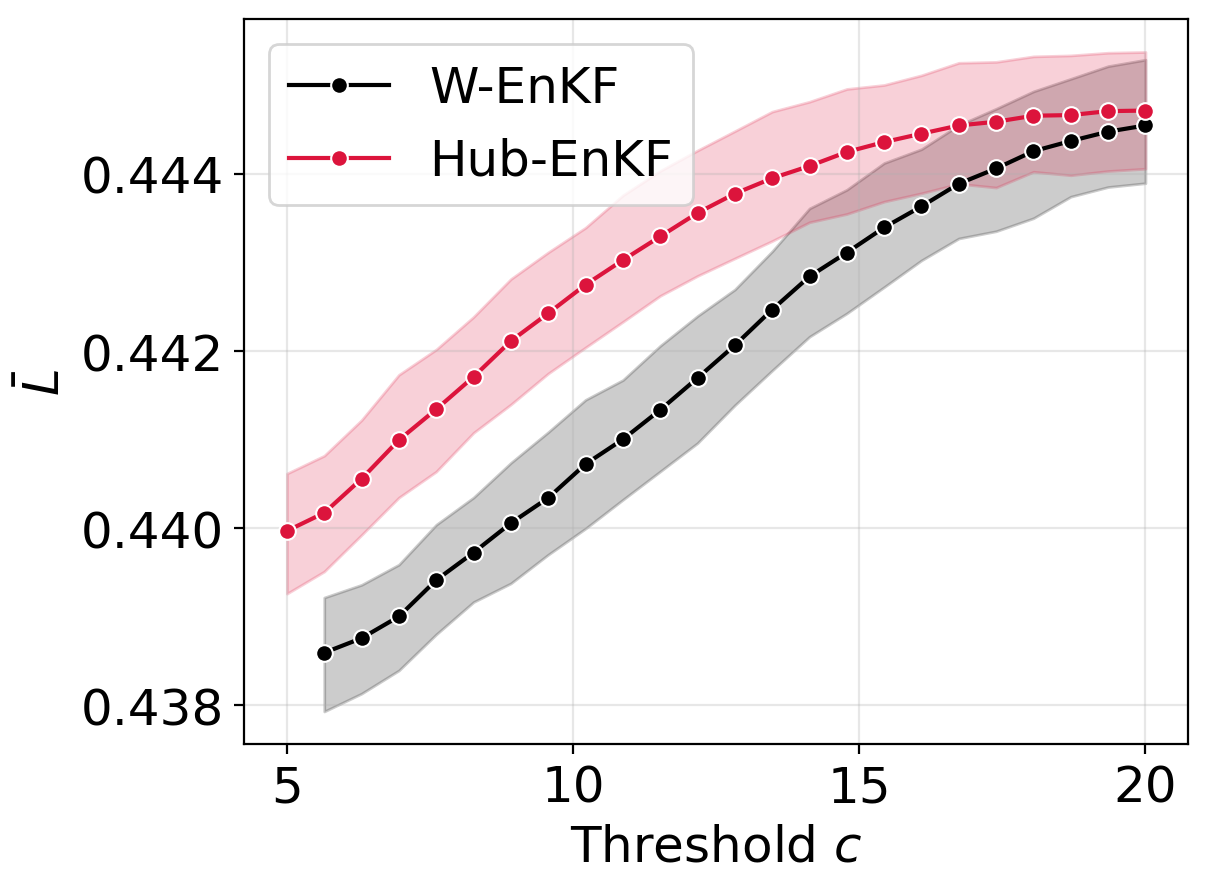

In [77]:
errs_df = pd.DataFrame(np.array(errs_wlenkf), columns=c_values)
sns.lineplot(
    x="variable",
    y="value",
    data=errs_df.melt().query("variable > 5"),
    color="black",
    marker="o",
    label="W-EnKF"
)


errs_df = pd.DataFrame(np.array(errs_hubenkf), columns=c_values)
sns.lineplot(
    x="variable",
    y="value",
    data=errs_df.melt(),
    color="crimson",
    marker="o",
    label="Hub-EnKF"
)


# plt.axhline(y=errs_enkf.mean(), linestyle="--", linewidth=2, c="teal", label="EnKF")
# xmin, xmax = plt.xlim()
# xrange = np.linspace(xmin, xmax)
# plt.fill_between(xrange, lbound, ubound, color="teal", alpha=0.3)
# plt.xlim(xmin, xmax)

plt.legend()
plt.xlabel("Threshold $c$")
plt.ylabel(r"$\bar{L}$")
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("./figures/lorenz96-wenkf-vs-enekf.png", dpi=300)

## An animation

In [ ]:
from matplotlib.animation import FuncAnimation

In [ ]:
snapshots = 150
N = 60 * snapshots
dt = 0.05
x0 = 8.0 + jax.random.normal(key_init, (D,))
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
xs = rk4(xs, dt, N, f)
ys = xs + jax.random.normal(key_measurement, xs.shape)
xs_cpu = np.array(xs)

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.7))
def anim(i):
    ax.cla()
    for n, row in enumerate(xs_cpu[i:i + 60][::-1]):
        ax.plot(
            (row - row.mean()) / row.std() + n * 0.4, c="black", linewidth=1.0, zorder=2,
            alpha = 1 - n / 60
        )
    ax.set_ylim(0, 59 * 0.4)
    ax.axis("off")
    plt.tight_layout()

animation = FuncAnimation(fig, anim, frames=snapshots)
animation.save("waves.gif", fps=10)